# Check Improvement over Prior

In [1]:
cd("calibrate/")

In [1]:
import Pkg
Pkg.status()

Status `~/ClimaAtmos.jl/calibration/experiments/reanalysis_forcing/Project.toml`
  [79e6a3ab] Adapt v4.1.1
  [c7e460c6] ArgParse v1.2.0
  [a14bc488] ArtifactWrappers v0.2.0
  [86bc3604] AtmosphericProfilesLibrary v0.1.7
⌅ [8e7c35d0] BlockArrays v0.16.43
  [052768ef] CUDA v5.5.2
⌅ [13f3f980] CairoMakie v0.11.11
⌃ [29b5916a] ClimaAnalysis v0.5.7
  [b2c96348] ClimaAtmos v0.27.6 `../../..`
  [4347a170] ClimaCalibrate v0.0.5
  [3a4d1b5c] ClimaComms v0.6.4
⌃ [d414da3d] ClimaCore v0.14.19
  [908f55d8] ClimaCoreMakie v0.4.6
  [cf7c7e5a] ClimaCorePlots v0.2.11
  [c2caaa1d] ClimaCoreSpectra v0.1.4
  [d934ef94] ClimaCoreTempestRemap v0.3.18
  [c8b6d40d] ClimaCoreVTK v0.7.6
  [1ecacbb8] ClimaDiagnostics v0.2.11
  [5c42b081] ClimaParams v0.10.18
  [e0c89595] ClimaReproducibilityTests v0.1.0
  [595c0a79] ClimaTimeSteppers v0.7.38
  [b3f4f4ca] ClimaUtilities v0.1.20
  [6a9e3e04] CloudMicrophysics v0.22.5
⌅ [5ae59095] Colors v0.12.11
  [2b5f629d] DiffEqBase v6.160.0
  [31c24e10] Distributions v0.25.11

In [14]:
using Revise 
using ClimaAnalysis
import ClimaAtmos as CA
using NCDatasets
import YAML
import Plots
import Glob
using CairoMakie
import ClimaAnalysis.Visualize as viz
import ClimaAnalysis.Utils: kwargs as ca_kwargs

import JLD2

import Interpolations
using Statistics

import TOML, YAML
import JLD2
using Distributions
import EnsembleKalmanProcesses as EKP
using EnsembleKalmanProcesses.ParameterDistributions
using EnsembleKalmanProcesses.TOMLInterface
import ClimaCalibrate as CAL

In [24]:
# code to get prior from eki object 
sim_path = "/scratch/julian/calibrations/precal_23/"
eki_initial = JLD2.load_object(joinpath(sim_path, "iteration_000/eki_file.jld2"))

eki_final = JLD2.load_object(joinpath(sim_path, "iteration_010/eki_file.jld2"));
prior = CAL.get_prior("calibrate/toml/prior_1m.toml");
t = TOML.parsefile("calibrate/toml/prior_1m.toml");

In [29]:
function get_ϕ_mean_final_nn(eki, prior, toml_final = "calibrate/toml/final_1m.toml")
    """
    Get the ensemble member of the final iteration closest to the ensemble mean 
    as measured in unconstrained space wrt 2-norm
    """
    u_final = EKP.get_u_final(eki)
    u_mean_final = EKP.get_u_mean_final(eki)
    best_member = argmin(sum((u_final .- u_mean_final) .^2, dims = 1))[2]

    # pick the best one in physical space
    ϕ_mean_final = EKP.get_ϕ_final(prior, eki)[:, best_member]

    # index and save to toml
    batch_idx = EKP.batch(prior)
    param_names = prior.name

    toml_dict = Dict(zip(param_names, [Dict("value" => length(ϕ_mean_final[idx]) == 1 ? ϕ_mean_final[idx][1] : ϕ_mean_final[idx]) for idx in batch_idx]))

    toml_string = TOML.print(toml_dict)
    open(toml_final, "w") do io 
        TOML.print(io, toml_dict)
    end
end

get_ϕ_mean_final_nn(eki_final, prior, "calibrate/toml/final_1m_nn.toml")



[entr_param_vec]
value = [-0.03970381530067492, 0.07421290749530188, 0.1805025566580846, 0.15494998443503677, -0.19559974680971823, -0.019943361845802376, -0.07811861534099573, 0.20460436569880988, 0.9866119459877382, -1.4075930614117624, 0.31464997909672837, 0.3192204792486643]

[EDMF_surface_area]
value = 0.11368116898355826

[mixing_length_eddy_viscosity_coefficient]
value = 0.022315219347084154

[snow_autoconversion_timescale]
value = 135.08789867674423

[turb_entr_param_vec]
value = [0.03710224326889695, 4452.656039570235]

[rain_autoconversion_timescale]
value = 6394.273609340287

[mixing_length_tke_surf_scale]
value = 0.3822230704689704

[mixing_length_diss_coeff]
value = 0.09622472269129516

[pressure_normalmode_drag_coeff]
value = 12.91939065706462

[mixing_length_Prandtl_number_0]
value = 1.2548014183245413

[diagnostic_covariance_coeff]
value = 2.0788545616973444

[mixing_length_static_stab_coeff]
value = 0.11452491152031997

[pressure_normalmode_buoy_coeff1]
value = 0.31224

In [31]:
# can we run a simulation with the final parameters?

# read in prog yaml file
config_dict = YAML.load_file("calibrate/prognostic_edmfx_gcmdriven_column.yml")
config_dict["toml"] = ["calibrate/toml/final_1m_nn.toml"]
config_dict["external_forcing_file"] = "data/era5_monthly_forcing_1.nc"
config_dict["t_end"] = "60mins" # short for debugging

config = CA.AtmosConfig(config_dict; job_id = "posterior_1m_nn")
simulation = CA.get_simulation(config)
sol_res = CA.solve_atmos!(simulation)

┌ Warning: Failed to convert `config_dict["truncation"] = 40000` to default type String, keeping original value
└ @ ClimaAtmos ~/ClimaAtmos.jl/src/solver/yaml_helper.jl:81
[ Info: Running on CPUSingleThreaded.
[ Info: Setting up single-process ClimaAtmos run
[ Info: Running ClimaCore in unthreaded mode.
┌ Info: Making AtmosConfig with config files: 
└    /home/jschmitt/ClimaAtmos.jl/src/solver/../../config/default_configs/default_config.yml
[ Info: Using CAM_SE hyperdiffusion. vorticity_hyperdiffusion_coefficient, scalar_hyperdiffusion_coefficient and divergence_damping_factor in the config will be ignored.
┌ Info: numerics 
│            `energy_upwinding`::`Val{:none}`
│            `tracer_upwinding`::`Val{:none}`
│             `edmfx_upwinding`::`Val{:first_order}`
│     `edmfx_sgsflux_upwinding`::`Val{:none}`
│     `test_dycore_consistency`::`Nothing`
└                     `limiter`::`Nothing`
┌ Info: AtmosModel: 
│ 
│                         `model_config`::`ClimaAtmos.SingleColumn

solve!:: 12.729604 seconds (4.70 M allocations: 367.331 MiB, 0.24% gc time, 15.27% compilation time)


[ Info: sypd: 0.775
[ Info: wall_time_per_timestep: 10 milliseconds, 608 microseconds
[ Info: Memory currently used (after solve!) by the process (RSS): 8.47 GiB


Simulation completed
├── Return code: success
└── Walltime: 12.729603519 seconds

In [ ]:
final_means = EKP.get_u_mean_final(eki_final) # returns a vector of final iteration parameter means
final_ens_means = EKP.get_u_final(eki_final)
best_member = argmin(sum((final_ens_means .- final_means) .^ 2, dims = 1))[2]

# pick the best one in physical space
final_means = EKP.get_ϕ_final(prior, eki_final)[:, best_member] 

batch_idx = EKP.batch(prior) # groups the parameters by name (useful for priors whith multiple parameters per named entry)
param_names = prior.name # get names

toml_dict = Dict(zip(param_names, [Dict("value" => length(final_means[idx]) == 1 ? final_means[idx][1] : final_means[idx]) for idx in batch_idx]))

toml_string = TOML.print(toml_dict)
open("calibrate/toml/final_1m.toml", "w") do io
    TOML.print(io, toml_dict)
end

[entr_param_vec]
value = [-0.03970381530067492, 0.07421290749530188, 0.1805025566580846, 0.15494998443503677, -0.19559974680971823, -0.019943361845802376, -0.07811861534099573, 0.20460436569880988, 0.9866119459877382, -1.4075930614117624, 0.31464997909672837, 0.3192204792486643]

[EDMF_surface_area]
value = 0.11368116898355826

[mixing_length_eddy_viscosity_coefficient]
value = 0.022315219347084154

[snow_autoconversion_timescale]
value = 135.08789867674423

[turb_entr_param_vec]
value = [0.03710224326889695, 4452.656039570235]

[rain_autoconversion_timescale]
value = 6394.273609340287

[mixing_length_tke_surf_scale]
value = 0.3822230704689704

[mixing_length_diss_coeff]
value = 0.09622472269129516

[pressure_normalmode_drag_coeff]
value = 12.91939065706462

[mixing_length_Prandtl_number_0]
value = 1.2548014183245413

[diagnostic_covariance_coeff]
value = 2.0788545616973444

[mixing_length_static_stab_coeff]
value = 0.11452491152031997

[pressure_normalmode_buoy_coeff1]
value = 0.31224

In [46]:
final_means = EKP.get_ϕ_mean_final(prior, eki_final) # returns a vector of final iteration parameter means
batch_idx = EKP.batch(prior) # groups the parameters by name (useful for priors whith multiple parameters per named entry)
param_names = prior.name # get names
# create new dictionary
toml_dict = Dict(zip(param_names, [Dict("value" => length(final_means[idx]) == 1 ? final_means[idx][1] : final_means[idx]) for idx in batch_idx]))
# save as toml
toml_string = TOML.print(toml_dict)
open("calibrate/toml/final_1m.toml", "w") do io
    TOML.print(io, toml_dict)
end

[entr_param_vec]
value = [0.003442182489355591, 0.06903836846872463, 0.0914676671211842, 0.23037899305668927, -0.2950265768583271, -0.0038959391934160303, -0.05127074801184167, 0.20432634859607027, 0.9044025195346118, -1.275736595854016, 0.2886467700011374, 0.2856062071555367]

[EDMF_surface_area]
value = 0.11633195640932877

[mixing_length_eddy_viscosity_coefficient]
value = 0.021705410449415968

[snow_autoconversion_timescale]
value = 136.68991909007073

[turb_entr_param_vec]
value = [0.035335654186203096, 4448.556119318102]

[rain_autoconversion_timescale]
value = 6388.528617764547

[mixing_length_tke_surf_scale]
value = 0.3790432045605149

[mixing_length_diss_coeff]
value = 0.08967440560475215

[pressure_normalmode_drag_coeff]
value = 13.347483037021817

[mixing_length_Prandtl_number_0]
value = 1.2295330880386002

[diagnostic_covariance_coeff]
value = 2.1068559854112934

[mixing_length_static_stab_coeff]
value = 0.11275478272490325

[pressure_normalmode_buoy_coeff1]
value = 0.31298

In [ ]:
# run for final configuration 
config_dict = YAML.load_file("prognostic_edmfx_gcmdriven_column.yml")
config_dict["toml"] = ["toml/final_1m.toml"]

config = CA.AtmosConfig(config_dict; job_id = "final_1m_precal_23")
simulation = CA.get_simulation(config)
sol_res = CA.solve_atmos!(simulation)

┌ Warning: Failed to convert `config_dict["truncation"] = 40000` to default type String, keeping original value
└ @ ClimaAtmos ~/ClimaAtmos.jl/src/solver/yaml_helper.jl:81
[ Info: Running on CPUSingleThreaded.
[ Info: Setting up single-process ClimaAtmos run
[ Info: Running ClimaCore in unthreaded mode.
┌ Info: Making AtmosConfig with config files: 
└    /home/jschmitt/ClimaAtmos.jl/src/solver/../../config/default_configs/default_config.yml
[ Info: Using CAM_SE hyperdiffusion. vorticity_hyperdiffusion_coefficient, scalar_hyperdiffusion_coefficient and divergence_damping_factor in the config will be ignored.
┌ Info: numerics 
│            `energy_upwinding`::`Val{:none}`
│            `tracer_upwinding`::`Val{:none}`
│             `edmfx_upwinding`::`Val{:first_order}`
│     `edmfx_sgsflux_upwinding`::`Val{:none}`
│     `test_dycore_consistency`::`Nothing`
└                     `limiter`::`Nothing`
┌ Info: AtmosModel: 
│ 
│                         `model_config`::`ClimaAtmos.SingleColumn

In [ ]:
# run climaatmos simulations for initial and final configurations
config_dict = YAML.load_file("prognostic_edmfx_gcmdriven_column.yml")
config_dict["toml"] = ["../toml/prognostic_edmfx_gcmdriven_precalibrated.toml"]

config = CA.AtmosConfig(config_dict; job_id = "precal_23_prior")
simulation = CA.get_simulation(config)
sol_res = CA.solve_atmos!(simulation)

┌ Warning: Failed to convert `config_dict["truncation"] = 40000` to default type String, keeping original value
└ @ ClimaAtmos ~/ClimaAtmos.jl/src/solver/yaml_helper.jl:81
[ Info: Running on CPUSingleThreaded.
[ Info: Setting up single-process ClimaAtmos run
[ Info: Running ClimaCore in unthreaded mode.
┌ Info: Making AtmosConfig with config files: 
└    /home/jschmitt/ClimaAtmos.jl/src/solver/../../config/default_configs/default_config.yml
[ Info: Using CAM_SE hyperdiffusion. vorticity_hyperdiffusion_coefficient, scalar_hyperdiffusion_coefficient and divergence_damping_factor in the config will be ignored.
┌ Info: numerics 
│            `energy_upwinding`::`Val{:none}`
│            `tracer_upwinding`::`Val{:none}`
│             `edmfx_upwinding`::`Val{:first_order}`
│     `edmfx_sgsflux_upwinding`::`Val{:none}`
│     `test_dycore_consistency`::`Nothing`
└                     `limiter`::`Nothing`
┌ Info: AtmosModel: 
│ 
│                         `model_config`::`ClimaAtmos.SingleColumn

LoadError: SystemError: opening file "output/precal_23/prior/output_0002/precal_23/prior_parameters.toml": No such file or directory

In [14]:
config_dict = YAML.load_file("prognostic_edmfx_gcmdriven_column.yml")
config_dict["toml"] = ["toml/prognostic_edmfx_gcmdriven_precalibrated.toml"]

config = CA.AtmosConfig(config_dict; job_id = "precal_23/prior")
simulation = CA.get_simulation(config)


┌ Warning: The configuration passed to ClimaAtmos contains unused keys: truncation
└ @ ClimaAtmos ~/.julia/packages/ClimaAtmos/MPMvB/src/solver/yaml_helper.jl:92
[ Info: Running on CPUSingleThreaded.
[ Info: Setting up single-process ClimaAtmos run
[ Info: Running ClimaCore in unthreaded mode.
┌ Info: Making AtmosConfig with config files: 
└    /home/jschmitt/.julia/packages/ClimaAtmos/MPMvB/src/solver/../../config/default_configs/default_config.yml


LoadError: AssertionError: external_forcing in (nothing, "GCM", "ISDAC")

In [ ]:
# run for final configuration 
config_dict = YAML.load_file("prognostic_edmfx_gcmdriven_column.yml")
config_dict["toml"] = [new_toml_dict]

config = CA.AtmosConfig(config_dict; job_id = "precal_23/final")
simulation = CA.get_simulation(config)
sol_res = CA.solve_atmos!(simulation)

# Visualize Against ERA5

In [ ]:
simdir_prior = SimDir("output/precal_23/prior/output_active")
simdir_final = SimDir("output/precal_23/final/output_active")

# get the data from the simulations



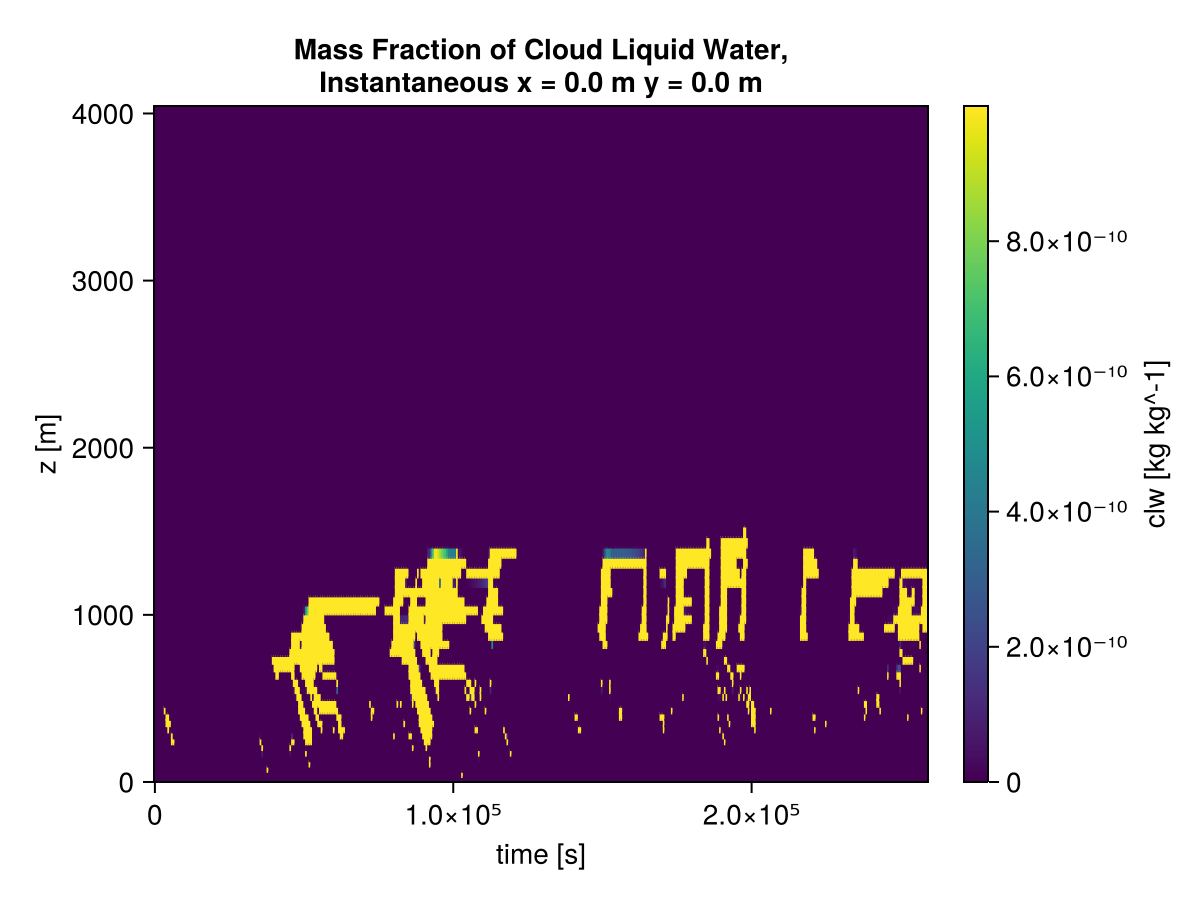

In [21]:
import ClimaAnalysis.Visualize as viz
using CairoMakie
using ClimaAnalysis
import ClimaAnalysis.Utils: kwargs as ca_kwargs

simdir = SimDir("/scratch/julian/calibrations/exp_1/iteration_006/member_001/config_2/output_active")
clw = get(simdir; short_name = "clw")

fig = Figure()

# create makie figure 
viz.heatmap!(
    fig,
    window(slice(clw, x=0, y=0), "z", left = 0, right = 4000);
    more_kwargs = Dict(
        :plot => ca_kwargs(alpha = 1, colorrange = (0, 0.000000001)),
        #:cb => ca_kwargs(label = "My label"),
        #:axis => ca_kwargs(subtitle = "My subtitle"),
    ),
    # more_kwargs= Dict(
    #     :plot => Dict(:limits => (0, 0.0001))
    # )
)

fig

In [24]:
# get clw profiles from the data
dirs = ["/scratch/julian/calibrations/exp_3_cf23_no_eddy_visc/iteration_010/member_$j/config_1/output_active" for j in [lpad(i, 3, '0') for i in 1:100]]
simdir = SimDir(dirs[1])

SimDir{Dict{Any, Any}, Dict{Any, Any}}("/scratch/julian/calibrations/exp_3_cf23_no_eddy_visc/iteration_010/member_001/config_1/output_active", Dict{Any, Any}("rhoa" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "/scratch/julian/calibrations/exp_3_cf23_no_eddy_visc/iteration_010/member_001/config_1/output_active/rhoa_10m_inst.nc")), "taen" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "/scratch/julian/calibrations/exp_3_cf23_no_eddy_visc/iteration_010/member_001/config_1/output_active/taen_10m_inst.nc")), "pr" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "/scratch/julian/calibrations/exp_3_cf23_no_eddy_visc/iteration_010/member_001/config_1/output_active/pr_10m_inst.nc")), "waup" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "/scratch/julian/calibrations/exp_3_cf23_no_eddy_visc/iteration_010/member_001/config_1/output_active/waup_10m_inst.nc")), "hurvi" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "/scratch/julian/calibrations/exp_3_cf23_no_eddy_visc/iter

In [ ]:
log.(window(slice(clw, x=0, y=0), "z", left = 0, right = 4000).data)

467×62 Matrix{Float32}:
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  …  -Inf       -Inf       -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf     -Inf       -Inf       -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf     -Inf       -Inf       -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf     -Inf       -Inf       -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf     -Inf       -Inf       -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  …  -Inf       -Inf       -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf     -Inf       -Inf       -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf     -Inf       -Inf       -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf     -Inf       -Inf       -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf     -Inf       -Inf       -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  …  -Inf       -Inf       -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf     -Inf       -Inf       -Inf
 -Inf  -Inf  -Inf  -Inf  -Inf  -Inf  -Inf     -Inf       -Inf       -Inf
   ⋮                       

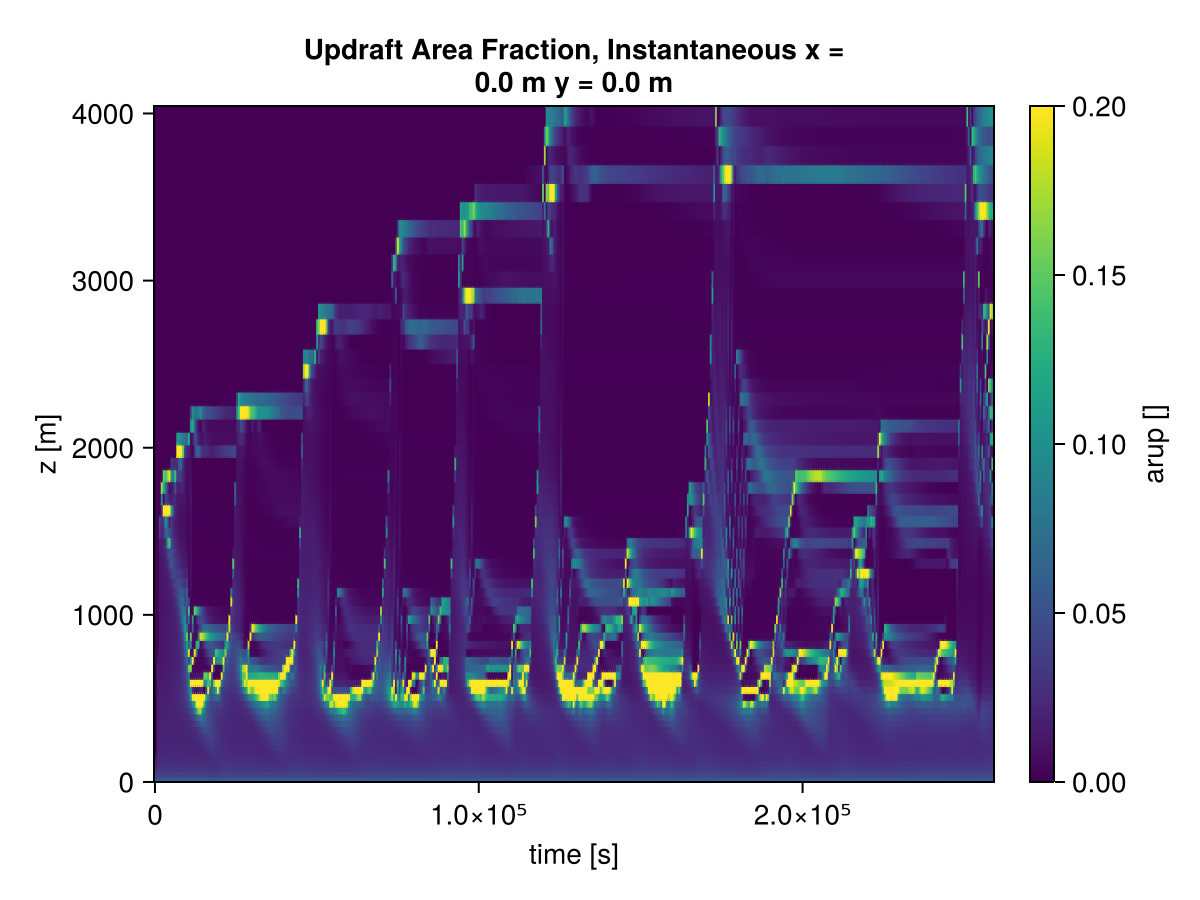

In [50]:
fig = Figure()
clw = get(simdir, "arup")

# create makie figure 
viz.heatmap!(
    fig,
    window(slice(clw, x=0, y=0), "z", left = 0, right = 4000);
    more_kwargs = Dict(
        :plot => ca_kwargs(alpha = 1, colorrange = (0, 0.2)),
        #:cb => ca_kwargs(label = "My label"),
        #:axis => ca_kwargs(yscale = log),
    ),
    # more_kwargs= Dict(
    #     :plot => Dict(:limits => (0, 0.0001))
    # )
)
fig

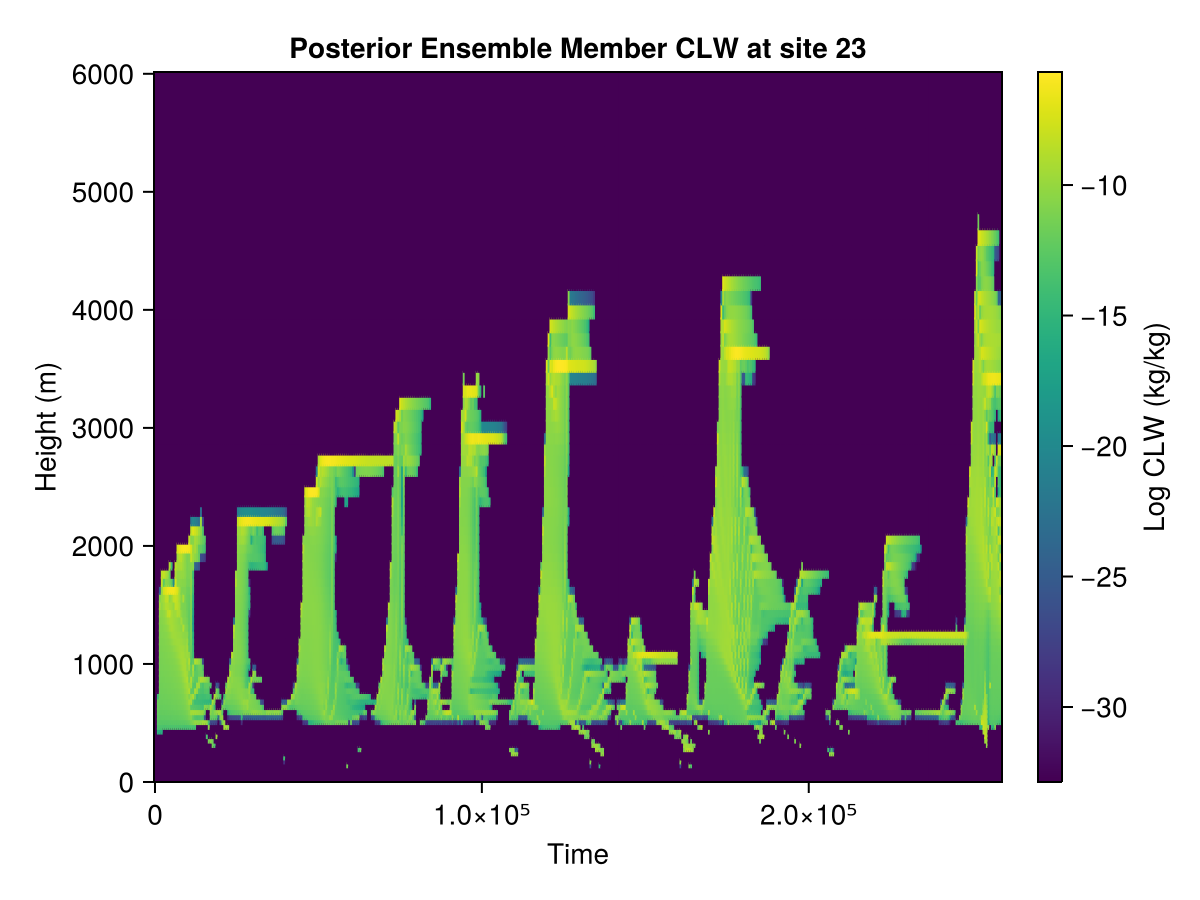

In [108]:
fig = Figure()

ax = Axis(fig[1, 1], xlabel = "Time", ylabel = "Height (m)",
        title = "Posterior Ensemble Member CLW at site 23")

clw = get(simdir, "clw")
t = window(slice(clw, x=0, y=0), "z", left = 0, right = 6000)

htm = Makie.heatmap!(ax, t.dims["time"], t.dims["z"], log.(t.data))
Makie.Colorbar(fig[1, 2], htm, label = "Log CLW (kg/kg)")

fig

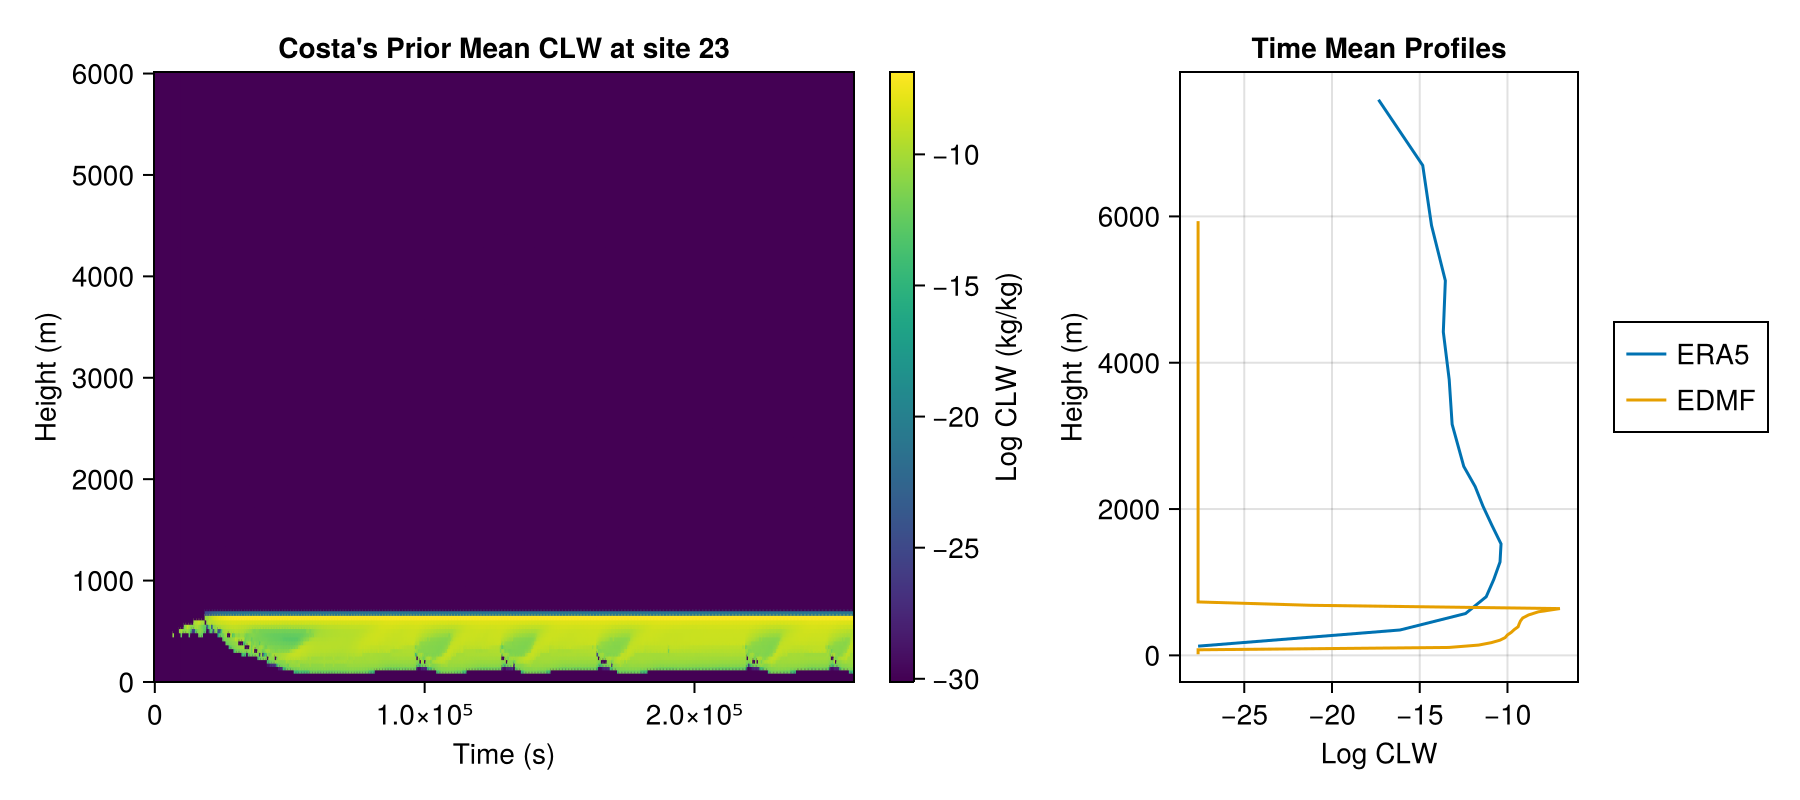

In [126]:
# initial simulation 
simdir_init = SimDir("calibrate/output/initial_1m_nn/output_active")

fig = Figure(size = (900, 400))

ax = Axis(fig[1, 1], xlabel = "Time (s)", ylabel = "Height (m)",
        title = "Costa's Prior Mean CLW at site 23")

clw = get(simdir_init, "clw")

t = window(slice(clw, x=0, y=0), "z", left = 0, right = 6000)
htm = Makie.heatmap!(ax, t.dims["time"], t.dims["z"], log.(t.data))

Colorbar(fig[1, 2], htm , label = "Log CLW (kg/kg)")


ax3 = Axis(fig[1, 3], xlabel = "Log CLW", ylabel = "Height (m)",
        title = "Time Mean Profiles")
Makie.lines!(ax3, log.(observations.group["site23"]["clw"][1:18, 7] .+ 1e-12), 
                        observations.group["site23"]["z"][1:18, 7] / 9.81, label = "ERA5")

Makie.lines!(ax3, log.(average_time(t).data .+ 1e-12), t.dims["z"], label = "EDMF")
fig[1, 4] = Legend(fig, ax3)

colsize!(fig.layout, 1, 350)
fig

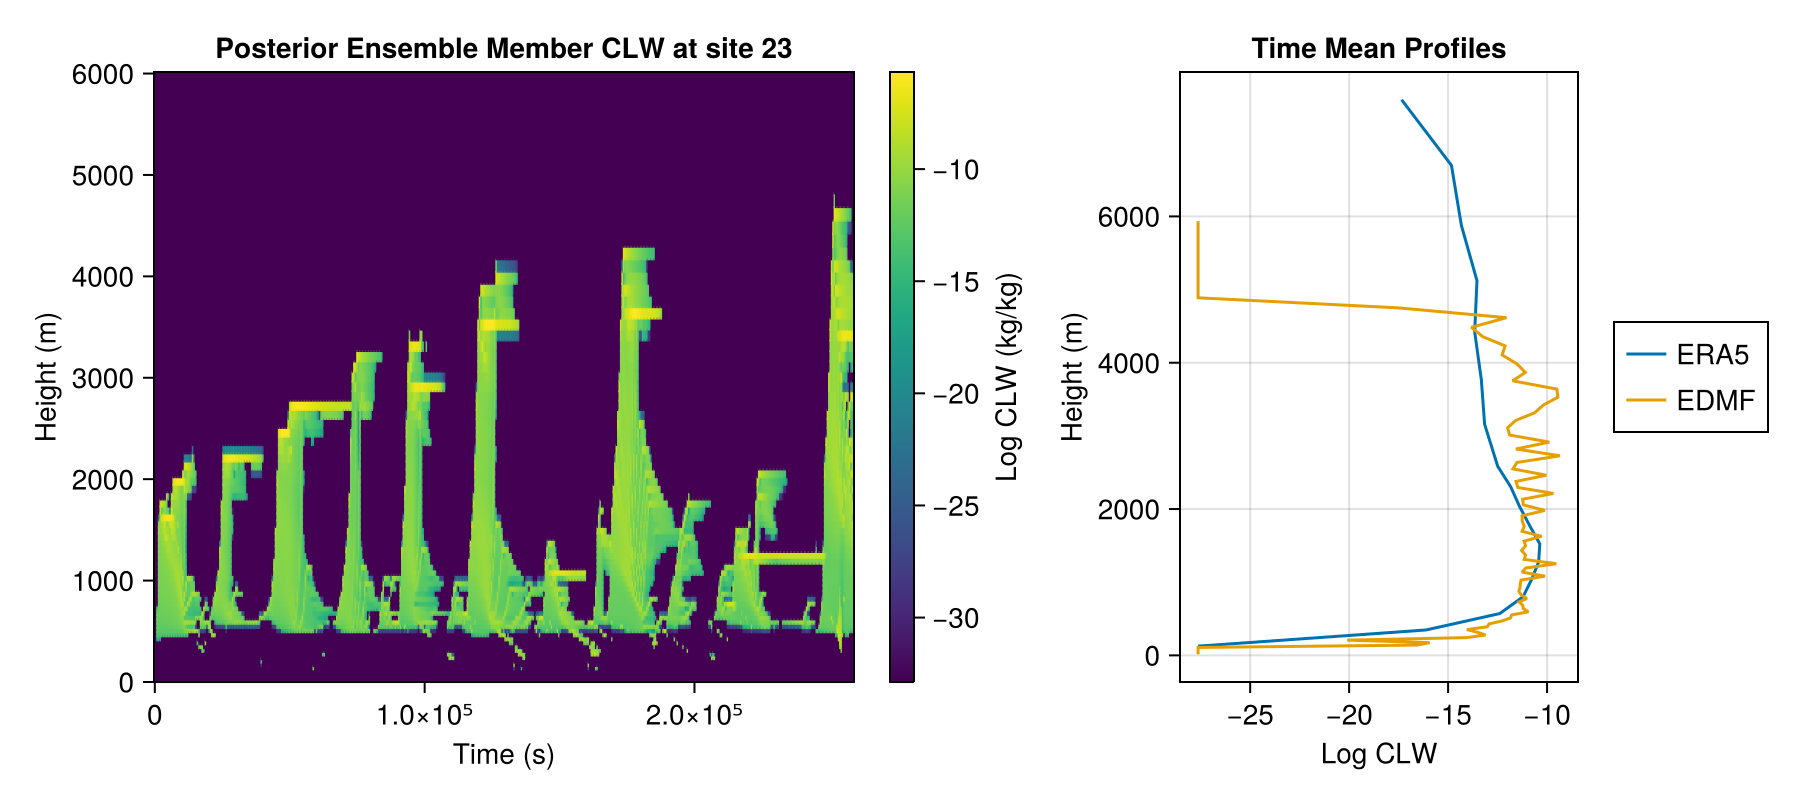

In [128]:
#t.dims["z"]
# initial simulation 
#simdir_init = SimDir("calibrate/output/initial_1m_nn/output_active")
simdir_init = simdir
fig = Figure(size = (900, 400))

ax = Axis(fig[1, 1], xlabel = "Time (s)", ylabel = "Height (m)",
        title = "Posterior Ensemble Member CLW at site 23")

clw = get(simdir_init, "clw")

t = window(slice(clw, x=0, y=0), "z", left = 0, right = 6000)
htm = Makie.heatmap!(ax, t.dims["time"], t.dims["z"], log.(t.data))

Colorbar(fig[1, 2], htm , label = "Log CLW (kg/kg)")


ax3 = Axis(fig[1, 3], xlabel = "Log CLW", ylabel = "Height (m)",
        title = "Time Mean Profiles")
Makie.lines!(ax3, log.(observations.group["site23"]["clw"][1:18, 7] .+ 1e-12), 
                        observations.group["site23"]["z"][1:18, 7] / 9.81, label = "ERA5")

Makie.lines!(ax3, log.(average_time(t).data .+ 1e-12), t.dims["z"], label = "EDMF")
fig[1, 4] = Legend(fig, ax3)

colsize!(fig.layout, 1, 350)
fig

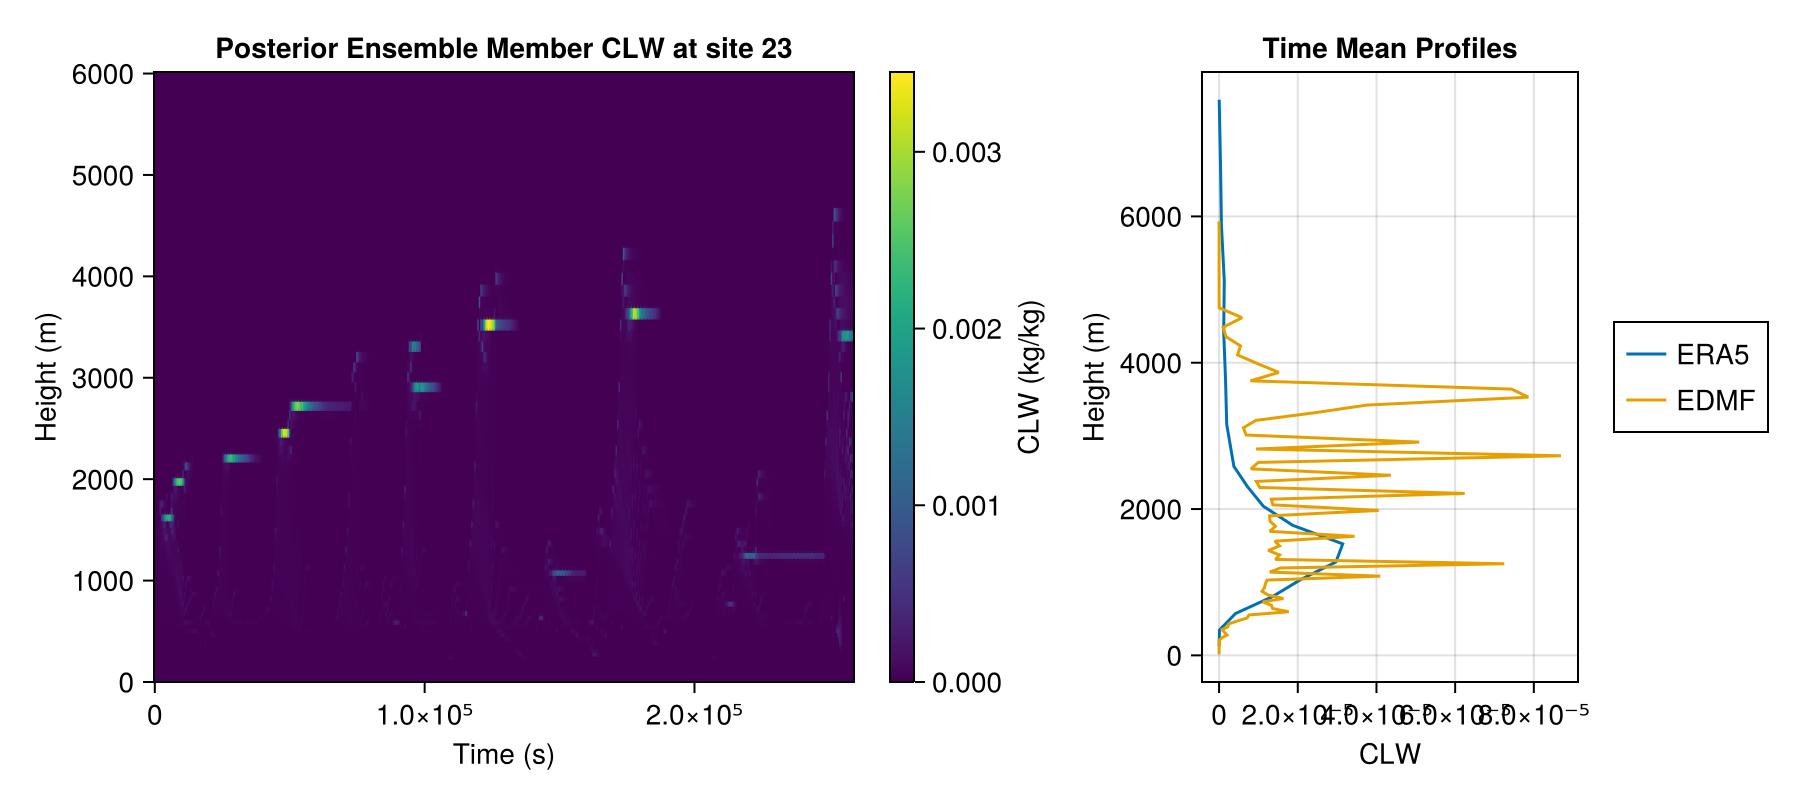

In [133]:
#simdir_init = SimDir("calibrate/output/initial_1m_nn/output_active")
simdir_init = simdir
fig = Figure(size = (900, 400))

ax = Axis(fig[1, 1], xlabel = "Time (s)", ylabel = "Height (m)",
        title = "Posterior Ensemble Member CLW at site 23")

clw = get(simdir_init, "clw")

t = window(slice(clw, x=0, y=0), "z", left = 0, right = 6000)
htm = Makie.heatmap!(ax, t.dims["time"], t.dims["z"], t.data)

Colorbar(fig[1, 2], htm , label = "CLW (kg/kg)")


ax3 = Axis(fig[1, 3], xlabel = "CLW", ylabel = "Height (m)",
        title = "Time Mean Profiles")
Makie.lines!(ax3, observations.group["site23"]["clw"][1:18, 7], 
                        observations.group["site23"]["z"][1:18, 7] / 9.81, label = "ERA5")

Makie.lines!(ax3, average_time(t).data, t.dims["z"], label = "EDMF")
fig[1, 4] = Legend(fig, ax3)

colsize!(fig.layout, 1, 350)
fig

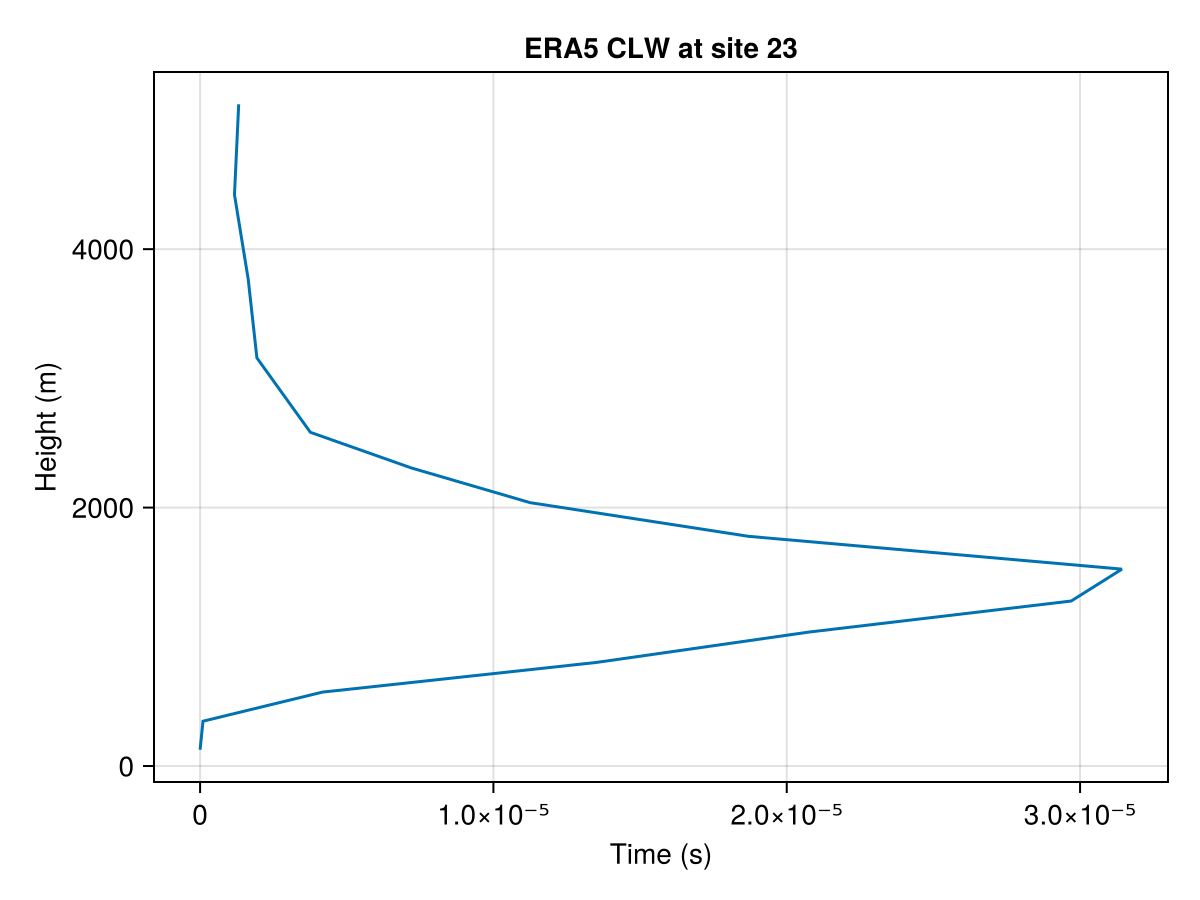

In [87]:
# get observational data
observations = NCDataset("data/era5_cfsite_obs_data.nc")
observations.group["site23"]["clw"][:, 7]

fig = Figure()

ax = Axis(fig[1, 1], xlabel = "Time (s)", ylabel = "Height (m)",
        title = "ERA5 CLW at site 23")

Makie.lines!(ax, observations.group["site23"]["clw"][1:15, 7], observations.group["site23"]["z"][1:15, 7] / 9.81)

fig

In [103]:
minimum(log.(observations.group["site23"]["clw"][1:18, 7] .+ 1e-12))

-27.631021115928547

# Get Observational Data